In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn import svm

## Prototype Model

Generate the prototypes

In [22]:
def gen_prototypes(X_train, y_train):
    ai_proto = np.mean(X_train[y_train == 'ai'], axis=0)
    real_proto = np.mean(X_train[y_train == 'real'], axis=0)
    return ai_proto, real_proto

Categorize each exemplar in the training set by distance to prototype

In [23]:
def prototype_predict(ai_proto, real_proto, stims):
    predictions = []

    for stim in stims:
        dist_ai = -np.linalg.norm(stim - ai_proto)
        dist_real = -np.linalg.norm(stim - real_proto)
        if dist_ai > dist_real:
            predictions.append('ai')
        else:
            predictions.append('real')
    
    return np.array(predictions)

## Exemplar Model

Generate lists of exemplars

In [24]:
def gen_exemplars(X_train, y_train):
    exemplars = {
        'ai': X_train[y_train == 'ai'],
        'real': X_train[y_train == 'real']
    }
    return exemplars

Categorize each exemplar based on highest similarity score to each category

In [25]:
def exemplar_predict(stims, exemplars, c=5.0):
    predictions = []
    for stim in stims:
        # Calculate distances considering all dimensions 
        distances_ai = np.linalg.norm(exemplars['ai'] - stim.reshape(1, -1), axis=1)
        distances_real = np.linalg.norm(exemplars['real'] - stim.reshape(1, -1), axis=1)
        
        # Calculate similarity scores
        sim_ai = np.sum(np.exp(-c * distances_ai))
        sim_real = np.sum(np.exp(-c * distances_real))
        
        # Make prediction based on highest similarity
        predictions.append('real' if sim_real > sim_ai else 'ai')
            
    return np.array(predictions)

### Results (with ML)

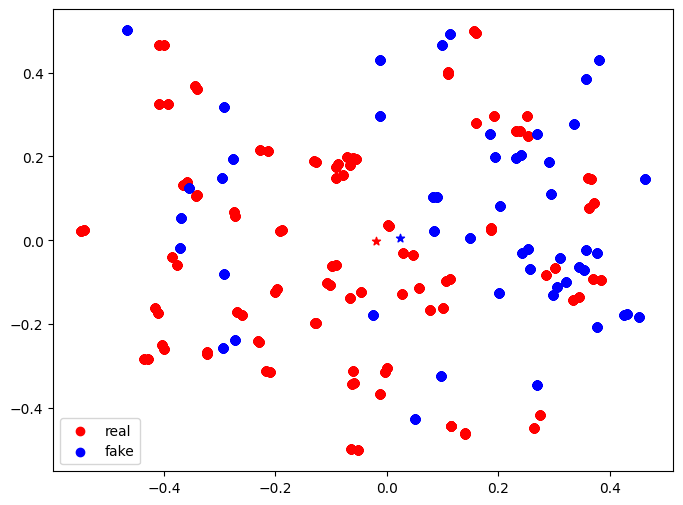

In [50]:
df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

df = pd.read_pickle('df_pca_2')  
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df = df.dropna(subset=["image"])  # Drop rows where 'image' is NaN
df["image"] = df["image"].astype(int)

df_merged = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 2)]

X = df_merged[pca_columns].values
y = df_merged["choice"].values

fake_proto, real_proto = gen_prototypes(X, y)

fig = plt.figure(figsize=(8, 6))
real = df_merged[df_merged['label'] == 'real']
fake = df_merged[df_merged['label'] == 'fake']

pla = plt.scatter(real[0], real[1], color='red')
plb = plt.scatter(fake[0], fake[1], color='blue')

plt.scatter(real_proto[0], real_proto[1], color='red', marker='*')
plt.scatter(fake_proto[0], fake_proto[1], color='blue', marker='*')

plt.legend([pla, plb], ["real", "fake"])


plt.show()

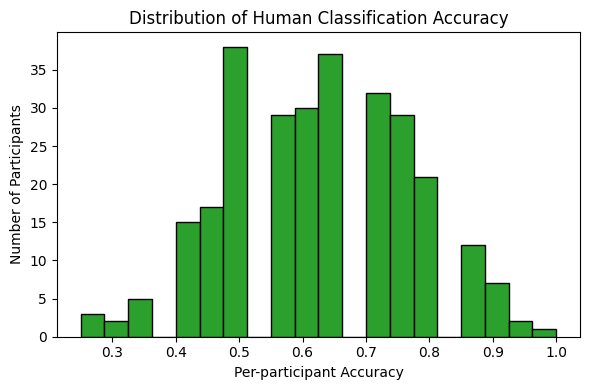

In [56]:
pp_acc = df_resp.groupby('ppantID')['correct'].apply(lambda x: (x == 'correct').mean())

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.hist(pp_acc, bins=20, color='C2', edgecolor='k')
plt.xlabel('Per-participant Accuracy')
plt.ylabel('Number of Participants')
plt.title('Distribution of Human Classification Accuracy')
plt.tight_layout()
plt.show()


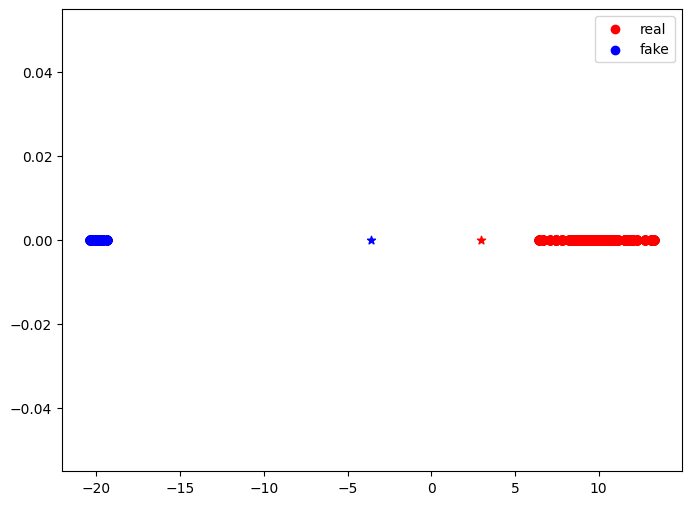

In [27]:
import matplotlib.pyplot as plt

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

df = pd.read_pickle('df_lda_1')  
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df = df.dropna(subset=["image"])  # Drop rows where 'image' is NaN
df["image"] = df["image"].astype(int)

df_merged = pd.merge(df_resp, df, on="image", how="inner")

X = df_merged[0].values
y = df_merged["choice"].values

fake_proto, real_proto = gen_prototypes(X, y)

fig = plt.figure(figsize=(8, 6))
real = df_merged[df_merged['label'] == 'real']
fake = df_merged[df_merged['label'] == 'fake']

y_coords_real = np.zeros(len(real[0]))
y_coords_fake = np.zeros(len(fake[0]))

pla = plt.scatter(real[0], y_coords_real, color='red')
plb = plt.scatter(fake[0], y_coords_fake, color='blue')

plt.scatter(real_proto, 0, color='red', marker='*')
plt.scatter(fake_proto, 0, color='blue', marker='*')

plt.legend([pla, plb], ["real", "fake"])


plt.show()

In [ ]:
# [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {
    1: 'df_pca_1',
    2:  'df_pca_2',
    3:  'df_pca_3',
    4:  'df_pca_4',
    5:  'df_pca_5',
    10: 'df_pca_10',
    20: 'df_pca_20',
    30: 'df_pca_30',
    50: 'df_pca_50',
    100:'df_pca_100'
    
}

results = []

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

for d, df_pca in pca_dfs.items():
    df = pd.read_pickle(df_pca)  
    df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
    df = df.dropna(subset=["image"])  # Drop rows where 'image' is NaN
    df["image"] = df["image"].astype(int)
    
    df_merged = pd.merge(df_resp, df, on="image", how="inner")
    pca_columns = [i for i in range(0, d)]
    
    confidence = 7
    df_merged = df_merged[df_merged["confidence"] >= confidence]
    
    X = df_merged[pca_columns].values
    y = df_merged["choice"].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Human
    human_acc = (df_merged['correct'] == 'correct').mean()

    # Prototype
    ai_proto, real_proto = gen_prototypes(X_train, y_train)
    proto_preds = prototype_predict(ai_proto, real_proto, X_test)
    proto_acc = accuracy_score(y_test, proto_preds)

    # Exemplar
    exemplars = gen_exemplars(X_train, y_train)
    exemplar_preds = exemplar_predict(X_test, exemplars, c=5.0)
    exemplar_acc = accuracy_score(y_test, exemplar_preds)

    # ML (RidgeClassifier)
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    ml_preds = clf.predict(X_test)
    ml_ridge_acc = accuracy_score(y_test, ml_preds)

    # ML (GradientBoostingClassifier)
    clf_gradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3)
    clf_gradientBoost.fit(X_train, y_train)
    ml_gradientBoost_preds = clf_gradientBoost.predict(X_test)
    ml_gradientBoost_acc = accuracy_score(y_test, ml_gradientBoost_preds)

    # ML (AdaBoostClassifier)
    clf_adaBoost = AdaBoostClassifier(n_estimators=100)
    clf_adaBoost.fit(X_train, y_train)
    ml_adaBoost_preds = clf_adaBoost.predict(X_test)
    ml_adaBoost_acc = accuracy_score(y_test, ml_adaBoost_preds)
    
    # ML (KNeighborsClassifier)
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    knn_acc = accuracy_score(y_test,knn_preds)

    # ML (BaggingClassifier)
    clf_bagging = BaggingClassifier(estimator = SVC(), n_estimators = 10)
    clf_bagging.fit(X_train, y_train)
    ml_bagging_preds = clf_bagging.predict(X_test)
    ml_bagging_acc = accuracy_score(y_test, ml_bagging_preds)
    
    results.append({
        "dims": d,
        "prototype_acc": proto_acc,
        "exemplar_acc": exemplar_acc,
        "ml_ridge_acc": ml_ridge_acc,
        "ml_gradientBoost_acc": ml_gradientBoost_acc,
        "ml_adaBoost_acc": ml_adaBoost_acc,
        "ml_knn_acc": knn_acc,
        "ml_bagging_acc": ml_bagging_acc,
        "human_acc": human_acc
    })

results_pca = pd.DataFrame(results)
print(results_pca)

   dims  prototype_acc  exemplar_acc  ml_ridge_acc  ml_gradientBoost_acc  \
0     1       0.589914      0.613701      0.613701              0.695528   
1     2       0.584206      0.613701      0.613701              0.695528   
2     3       0.574691      0.613701      0.613701              0.695528   
3     4       0.581351      0.613701      0.613701              0.697431   
4     5       0.579448      0.615604      0.613701              0.697431   
5    10       0.579448      0.670790      0.606089              0.695528   
6    20       0.621313      0.692674      0.642245              0.697431   
7    30       0.630828      0.690771      0.669838              0.697431   
8    50       0.643197      0.698382      0.666032              0.695528   
9   100       0.643197      0.698382      0.666032              0.697431   

   ml_adaBoost_acc  ml_knn_acc  ml_bagging_acc  human_acc  
0         0.652712    0.653663        0.613701   0.659623  
1         0.664129    0.639391        0.630

In [29]:
df = pd.read_pickle('df_lda_1')  
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df = df.dropna(subset=["image"])  # Drop rows where 'image' is NaN
df["image"] = df["image"].astype(int)

df_merged = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 1)]
df_merged = df_merged[df_merged["confidence"] >= confidence]

X = df_merged[pca_columns].values
y = df_merged["choice"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Prototype
ai_proto, real_proto = gen_prototypes(X_train, y_train)
proto_preds = prototype_predict(ai_proto, real_proto, X_test)
proto_acc = accuracy_score(y_test, proto_preds)

# Exemplar
exemplars = gen_exemplars(X_train, y_train)
exemplar_preds = exemplar_predict(X_test, exemplars, c=5.0)
exemplar_acc = accuracy_score(y_test, exemplar_preds)

# ML (RidgeClassifier)
clf = RidgeClassifier()
clf.fit(X_train, y_train)
ml_preds = clf.predict(X_test)
ml_ridge_acc = accuracy_score(y_test, ml_preds)

# ML (GradientBoostingClassifier)
clf_gradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=3)
clf_gradientBoost.fit(X_train, y_train)
ml_gradientBoost_preds = clf_gradientBoost.predict(X_test)
ml_gradientBoost_acc = accuracy_score(y_test, ml_gradientBoost_preds)

# ML (AdaBoostClassifier)
clf_adaBoost = AdaBoostClassifier(n_estimators=100)
clf_adaBoost.fit(X_train, y_train)
ml_adaBoost_preds = clf_adaBoost.predict(X_test)
ml_adaBoost_acc = accuracy_score(y_test, ml_adaBoost_preds)

# ML (KNeighborsClassifier)
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test,knn_preds)

# ML (BaggingClassifier)
clf_bagging = BaggingClassifier(estimator = SVC(), n_estimators = 10)
clf_bagging.fit(X_train, y_train)
ml_bagging_preds = clf_bagging.predict(X_test)
ml_bagging_acc = accuracy_score(y_test, ml_bagging_preds)

results = [{
    "dims": 1,
    "prototype_acc": proto_acc,
    "exemplar_acc": exemplar_acc,
    "ml_ridge_acc": ml_ridge_acc,
    "ml_gradientBoost_acc": ml_gradientBoost_acc,
    "ml_adaBoost_acc": ml_adaBoost_acc,
    "ml_knn_acc": knn_acc,
    "ml_bagging_acc": ml_bagging_acc,
}]

results_df_lda = pd.DataFrame(results)
print(results_df_lda)

   dims  prototype_acc  exemplar_acc  ml_ridge_acc  ml_gradientBoost_acc  \
0     1       0.667935      0.667935      0.667935              0.697431   

   ml_adaBoost_acc  ml_knn_acc  ml_bagging_acc  
0         0.667935    0.656518        0.667935  


In [30]:
df = pd.read_pickle('embed_dataset.pkl')  
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df = df.dropna(subset=["image"])  # Drop rows where 'image' is NaN
df["image"] = df["image"].astype(int)

df_merged = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 512)]
df_merged = df_merged[df_merged["confidence"] >= confidence]

X = np.vstack(df_merged["embeddings"].values)
y = df_merged["choice"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Prototype
ai_proto, real_proto = gen_prototypes(X_train, y_train)
proto_preds = prototype_predict(ai_proto, real_proto, X_test)
proto_acc = accuracy_score(y_test, proto_preds)

# Exemplar
exemplars = gen_exemplars(X_train, y_train)
exemplar_preds = exemplar_predict(X_test, exemplars, c=5.0)
exemplar_acc = accuracy_score(y_test, exemplar_preds)

# ML (RidgeClassifier)
clf = RidgeClassifier()
clf.fit(X_train, y_train)
ml_preds = clf.predict(X_test)
ml_ridge_acc = accuracy_score(y_test, ml_preds)

# ML (GradientBoostingClassifier)
clf_gradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=3)
clf_gradientBoost.fit(X_train, y_train)
ml_gradientBoost_preds = clf_gradientBoost.predict(X_test)
ml_gradientBoost_acc = accuracy_score(y_test, ml_gradientBoost_preds)

# ML (AdaBoostClassifier)
clf_adaBoost = AdaBoostClassifier(n_estimators=100)
clf_adaBoost.fit(X_train, y_train)
ml_adaBoost_preds = clf_adaBoost.predict(X_test)
ml_adaBoost_acc = accuracy_score(y_test, ml_adaBoost_preds)

# ML (KNeighborsClassifier)
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test,knn_preds)

# ML (BaggingClassifier)
clf_bagging = BaggingClassifier(estimator = SVC(), n_estimators = 10)
clf_bagging.fit(X_train, y_train)
ml_bagging_preds = clf_bagging.predict(X_test)
ml_bagging_acc = accuracy_score(y_test, ml_bagging_preds)

# ML (SVM)
clf_svm = svm.SVC()
clf_svm.fit(X_train, y_train)
svm_preds = clf_svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)

results = [{
    "dims": len(X[0]),
    "prototype_acc": proto_acc,
    "exemplar_acc": exemplar_acc,
    "ml_ridge_acc": ml_ridge_acc,
    "ml_gradientBoost_acc": ml_gradientBoost_acc,
    "ml_adaBoost_acc": ml_adaBoost_acc,
    "ml_knn_acc": knn_acc,
    "ml_bagging_acc": ml_bagging_acc,
    "svm_acc": svm_acc,
}]

results_svm = pd.DataFrame(results)
print(results_svm)

   dims  prototype_acc  exemplar_acc  ml_ridge_acc  ml_gradientBoost_acc  \
0   512       0.643197      0.698382      0.666032              0.697431   

   ml_adaBoost_acc  ml_knn_acc  ml_bagging_acc   svm_acc  
0         0.693625    0.673644        0.701237  0.698382  


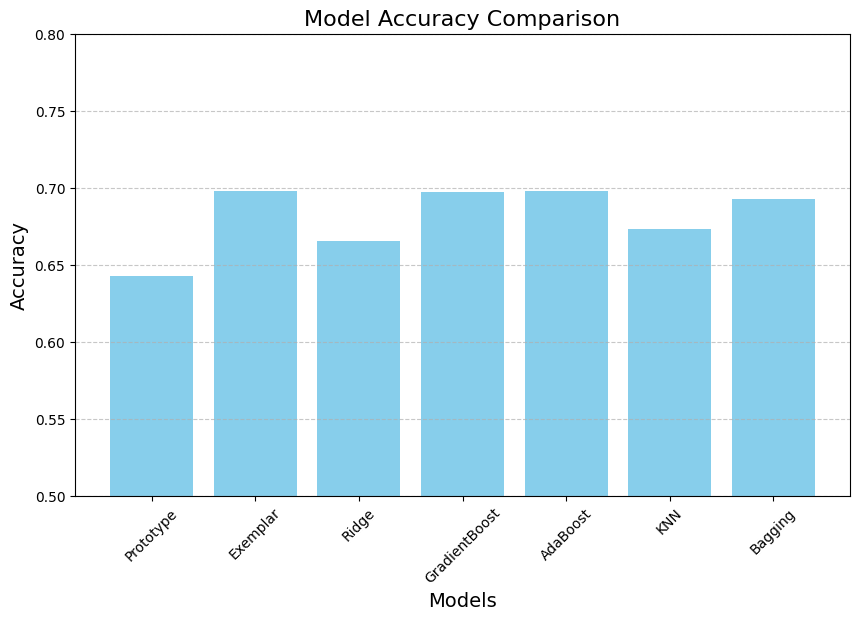

In [ ]:
import matplotlib.pyplot as plt

# Extract model names and their corresponding accuracies
models = ['Prototype', 'Exemplar', 'Ridge', 'GradientBoost', 'AdaBoost', 'KNN', 'Bagging']
accuracies = [
    results_pca['prototype_acc'].iloc[-1],
    results_pca['exemplar_acc'].iloc[-1],
    results_pca['ml_ridge_acc'].iloc[-1],
    results_pca['ml_gradientBoost_acc'].iloc[-1],
    results_pca['ml_adaBoost_acc'].iloc[-1],
    results_pca['ml_knn_acc'].iloc[-1],
    results_pca['ml_bagging_acc'].iloc[-1]
]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0.5, 0.8)  # Adjust the y-axis range for better visualization
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

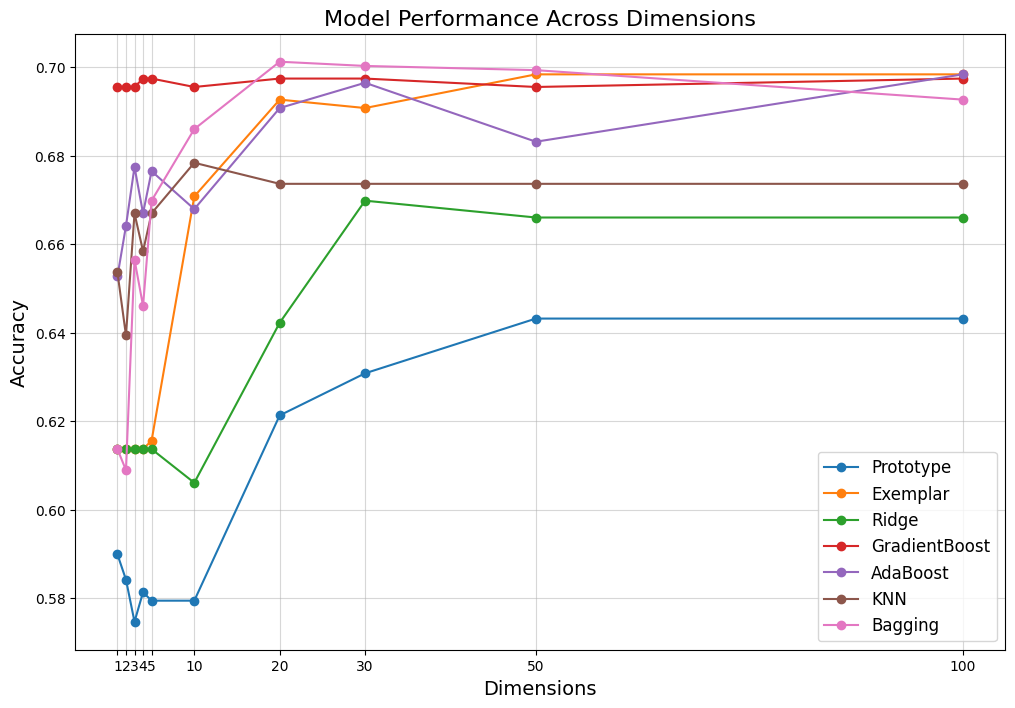

In [ ]:
# Extract data for plotting
dims = results_pca['dims']
prototype_acc = results_pca['prototype_acc']
exemplar_acc = results_pca['exemplar_acc']
ml_ridge_acc = results_pca['ml_ridge_acc']
ml_gradientBoost_acc = results_pca['ml_gradientBoost_acc']
ml_adaBoost_acc = results_pca['ml_adaBoost_acc']
ml_knn_acc = results_pca['ml_knn_acc']
ml_bagging_acc = results_pca['ml_bagging_acc']

# Plot the line chart
plt.figure(figsize=(12, 8))
plt.plot(dims, prototype_acc, label='Prototype', marker='o')
plt.plot(dims, exemplar_acc, label='Exemplar', marker='o')
plt.plot(dims, ml_ridge_acc, label='Ridge', marker='o')
plt.plot(dims, ml_gradientBoost_acc, label='GradientBoost', marker='o')
plt.plot(dims, ml_adaBoost_acc, label='AdaBoost', marker='o')
plt.plot(dims, ml_knn_acc, label='KNN', marker='o')
plt.plot(dims, ml_bagging_acc, label='Bagging', marker='o')

# Add labels, title, and legend
plt.title('Model Performance Across Dimensions', fontsize=16)
plt.xlabel('Dimensions', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.xticks(dims)

# Show the plot
plt.show()

Text(0.5, 1.0, 'Human vs. Prototype vs. Exemplar')

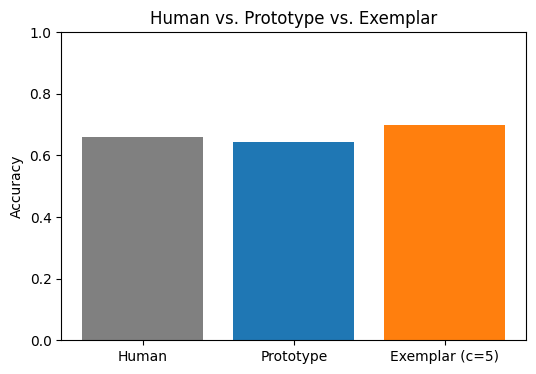

In [46]:
model_accs = {
    'Human': 0.659623,
    'Prototype': results_pca['prototype_acc'].max(),
    'Exemplar (c=5)': results_pca['exemplar_acc'].max()
}

plt.figure(figsize=(6,4))
plt.bar(model_accs.keys(), model_accs.values(), color=['gray','C0','C1'])
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Human vs. Prototype vs. Exemplar')